# Business Health Analysis

Primary analysis focusing on order trends, revenue impact, cancellations, and geographic performance.

## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/input/RPC_18_Datasets')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Data

In [2]:
df_customer = pd.read_csv(DATA_DIR / 'dim_customer.csv')
df_restaurant = pd.read_csv(DATA_DIR / 'dim_restaurant.csv')
df_orders = pd.read_csv(DATA_DIR / 'fact_orders.csv')
df_order_items = pd.read_csv(DATA_DIR / 'fact_order_items.csv')

# Convert dates
df_orders['order_timestamp'] = pd.to_datetime(df_orders['order_timestamp'])
df_customer['signup_date'] = pd.to_datetime(df_customer['signup_date'], format='%d-%m-%Y')

# Add time columns
df_orders['month'] = df_orders['order_timestamp'].dt.month
df_orders['year'] = df_orders['order_timestamp'].dt.year
df_orders['month_period'] = df_orders['order_timestamp'].dt.to_period('M')

print(f"Loaded {len(df_orders):,} orders from {df_orders['order_timestamp'].min()} to {df_orders['order_timestamp'].max()}")

Loaded 149,166 orders from 2025-01-01 12:00:00 to 2025-09-30 22:59:00


## Crisis Impact Snapshot

In [3]:
pre_crisis = df_orders[(df_orders['year'] == 2025) & (df_orders['month'].between(1, 5))]
crisis = df_orders[(df_orders['year'] == 2025) & (df_orders['month'].between(6, 9))]

pre_crisis_avg = len(pre_crisis) / 5
crisis_avg = len(crisis) / 4
decline_pct = (pre_crisis_avg - crisis_avg) / pre_crisis_avg * 100

print("CRISIS IMPACT SNAPSHOT")
print("=" * 60)
print(f"Pre-Crisis Period (Jan-May 2025): {len(pre_crisis):,} orders")
print(f"Crisis Period (Jun-Sep 2025): {len(crisis):,} orders")
print(f"\nAverage Monthly Orders:")
print(f"  Pre-Crisis: {pre_crisis_avg:,.0f}")
print(f"  Crisis: {crisis_avg:,.0f}")
print(f"\nDecline: {decline_pct:.1f}%")
print(f"Lost Orders: {pre_crisis_avg - crisis_avg:,.0f} per month")

CRISIS IMPACT SNAPSHOT
Pre-Crisis Period (Jan-May 2025): 113,806 orders
Crisis Period (Jun-Sep 2025): 35,360 orders

Average Monthly Orders:
  Pre-Crisis: 22,761
  Crisis: 8,840

Decline: 61.2%
Lost Orders: 13,921 per month


## Q1: Monthly Order Trends

MONTHLY ORDER TRENDS
month_period  orders   change  change_pct
     2025-01   23539      NaN         NaN
     2025-02   22667   -872.0   -3.704490
     2025-03   23543    876.0    3.864649
     2025-04   21466  -2077.0   -8.822155
     2025-05   22591   1125.0    5.240846
     2025-06    9293 -13298.0  -58.864149
     2025-07    8818   -475.0   -5.111374
     2025-08    8555   -263.0   -2.982536
     2025-09    8694    139.0    1.624781


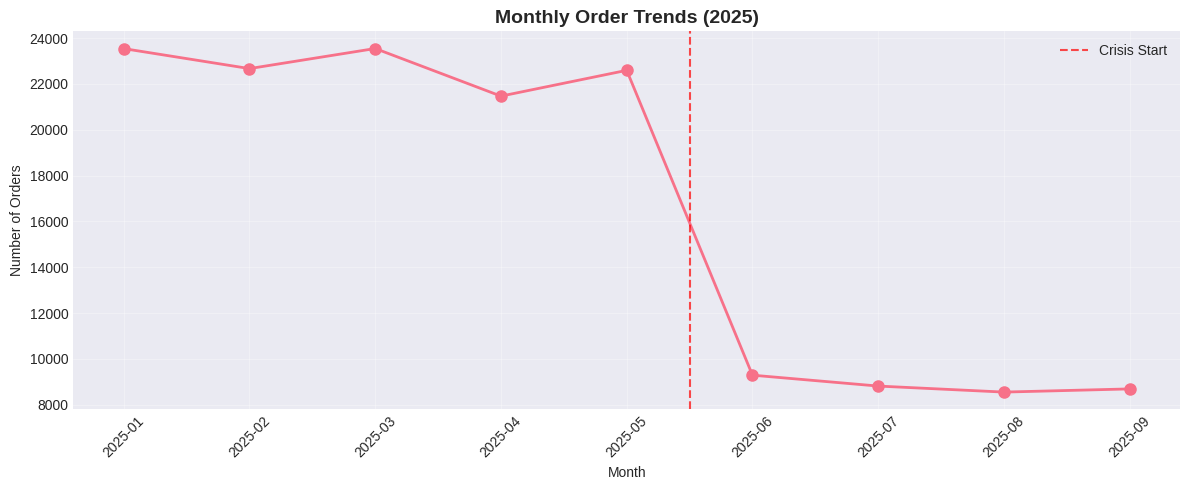

In [4]:
monthly_orders = df_orders.groupby('month_period').size().reset_index(name='orders')
monthly_orders['month_period'] = monthly_orders['month_period'].astype(str)
monthly_orders['change'] = monthly_orders['orders'].diff()
monthly_orders['change_pct'] = monthly_orders['orders'].pct_change() * 100

print("MONTHLY ORDER TRENDS")
print("=" * 60)
print(monthly_orders.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(monthly_orders['month_period'], monthly_orders['orders'], marker='o', linewidth=2, markersize=8)
plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
plt.title('Monthly Order Trends (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Q8: Revenue Impact Analysis

In [5]:
monthly_revenue = df_orders.groupby('month_period').agg({
    'subtotal_amount': 'sum',
    'discount_amount': 'sum',
    'delivery_fee': 'sum',
    'total_amount': 'sum'
}).reset_index()

monthly_revenue['month_period'] = monthly_revenue['month_period'].astype(str)
monthly_revenue['revenue_change'] = monthly_revenue['total_amount'].diff()
monthly_revenue['revenue_change_pct'] = monthly_revenue['total_amount'].pct_change() * 100

print("MONTHLY REVENUE BREAKDOWN")
print("=" * 80)
print(monthly_revenue.to_string(index=False))

# Revenue loss calculation
pre_crisis_revenue = pre_crisis['total_amount'].sum()
crisis_revenue = crisis['total_amount'].sum()
revenue_loss = pre_crisis_revenue - crisis_revenue

print(f"\nREVENUE IMPACT")
print("=" * 60)
print(f"Pre-Crisis Total Revenue: ₹{pre_crisis_revenue:,.2f}")
print(f"Crisis Total Revenue: ₹{crisis_revenue:,.2f}")
print(f"Revenue Loss: ₹{revenue_loss:,.2f}")
print(f"Revenue Decline: {(revenue_loss/pre_crisis_revenue*100):.1f}%")

MONTHLY REVENUE BREAKDOWN
month_period  subtotal_amount  discount_amount  delivery_fee  total_amount  revenue_change  revenue_change_pct
     2025-01       7512822.09        455289.57     716760.77    7774293.34             NaN                 NaN
     2025-02       7214790.37        435903.44     691066.05    7469953.31      -304340.03           -3.914697
     2025-03       7533281.86        449403.14     718691.44    7802568.99       332615.68            4.452714
     2025-04       6882073.23        413160.67     658059.94    7126972.24      -675596.75           -8.658645
     2025-05       7195624.36        436547.78     688099.54    7447176.37       320204.13            4.492849
     2025-06       2789338.26        168521.52     267050.00    2887866.91     -4559309.46          -61.221988
     2025-07       2628719.96        156444.88     252347.56    2724623.29      -163243.62           -5.652740
     2025-08       2551068.95        152041.70     243828.90    2642856.29       -8176

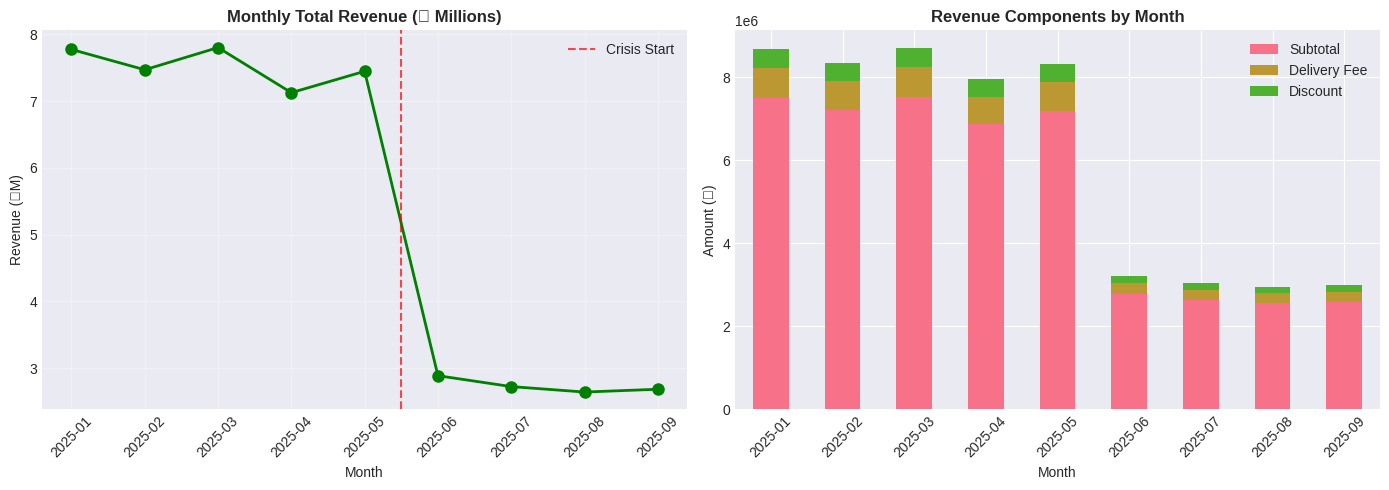

In [6]:
# Visualize revenue trends
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Total revenue trend
ax1.plot(monthly_revenue['month_period'], monthly_revenue['total_amount']/1000000, 
         marker='o', linewidth=2, markersize=8, color='green')
ax1.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
ax1.set_title('Monthly Total Revenue (₹ Millions)', fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (₹M)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Revenue components
revenue_components = monthly_revenue[['month_period', 'subtotal_amount', 'delivery_fee', 'discount_amount']]
revenue_components = revenue_components.set_index('month_period')
revenue_components.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Revenue Components by Month', fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Amount (₹)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['Subtotal', 'Delivery Fee', 'Discount'])

plt.tight_layout()
plt.show()

## Q4: Cancellation Analysis

In [7]:
monthly_cancellations = df_orders.groupby('month_period').agg({
    'is_cancelled': [
        ('total', 'count'),
        ('cancelled', lambda x: (x == 'Y').sum())
    ]
}).reset_index()

monthly_cancellations.columns = ['month_period', 'total_orders', 'cancelled_orders']
monthly_cancellations['cancellation_rate'] = (
    monthly_cancellations['cancelled_orders'] / monthly_cancellations['total_orders'] * 100
)
monthly_cancellations['month_period'] = monthly_cancellations['month_period'].astype(str)

print("MONTHLY CANCELLATION RATES")
print("=" * 60)
print(monthly_cancellations.to_string(index=False))

# Pre-crisis vs crisis cancellation rates
pre_crisis_cancel_rate = (pre_crisis['is_cancelled'] == 'Y').sum() / len(pre_crisis) * 100
crisis_cancel_rate = (crisis['is_cancelled'] == 'Y').sum() / len(crisis) * 100

print(f"\nCANCELLATION RATE COMPARISON")
print("=" * 60)
print(f"Pre-Crisis Cancellation Rate: {pre_crisis_cancel_rate:.2f}%")
print(f"Crisis Cancellation Rate: {crisis_cancel_rate:.2f}%")
print(f"Change: {crisis_cancel_rate - pre_crisis_cancel_rate:+.2f} percentage points")

MONTHLY CANCELLATION RATES
month_period  total_orders  cancelled_orders  cancellation_rate
     2025-01         23539              1463           6.215217
     2025-02         22667              1395           6.154321
     2025-03         23543              1410           5.989041
     2025-04         21466              1256           5.851113
     2025-05         22591              1370           6.064362
     2025-06          9293              1074          11.557086
     2025-07          8818              1050          11.907462
     2025-08          8555              1070          12.507306
     2025-09          8694              1024          11.778238

CANCELLATION RATE COMPARISON
Pre-Crisis Cancellation Rate: 6.06%
Crisis Cancellation Rate: 11.93%
Change: +5.87 percentage points


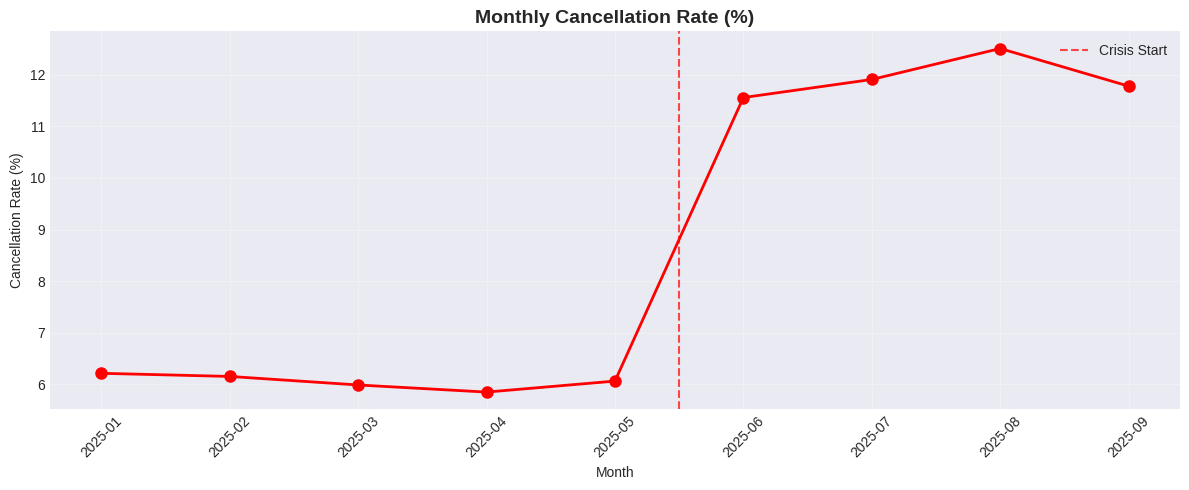

In [8]:
# Visualize cancellation rates
plt.figure(figsize=(12, 5))
plt.plot(monthly_cancellations['month_period'], monthly_cancellations['cancellation_rate'], 
         marker='o', linewidth=2, markersize=8, color='red')
plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
plt.title('Monthly Cancellation Rate (%)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Q2: City-Level Impact Analysis

In [9]:
# Merge orders with customer city
df_orders_city = df_orders.merge(df_customer[['customer_id', 'city']], on='customer_id', how='left')

# Filter non-cancelled orders for accurate city performance
df_orders_city_active = df_orders_city[df_orders_city['is_cancelled'] == 'N']

# Calculate pre-crisis and crisis orders by city
pre_crisis_city = df_orders_city_active[
    (df_orders_city_active['year'] == 2025) & 
    (df_orders_city_active['month'].between(1, 5))
].groupby('city').size()

crisis_city = df_orders_city_active[
    (df_orders_city_active['year'] == 2025) & 
    (df_orders_city_active['month'].between(6, 9))
].groupby('city').size()

# Calculate decline
city_comparison = pd.DataFrame({
    'pre_crisis_orders': pre_crisis_city,
    'crisis_orders': crisis_city
}).fillna(0)

city_comparison['decline_pct'] = (
    (city_comparison['crisis_orders'] - city_comparison['pre_crisis_orders']) / 
    city_comparison['pre_crisis_orders'] * 100
)
city_comparison['avg_pre_crisis'] = city_comparison['pre_crisis_orders'] / 5
city_comparison['avg_crisis'] = city_comparison['crisis_orders'] / 4

city_comparison = city_comparison.sort_values('decline_pct')

print("CITY-LEVEL ORDER IMPACT")
print("=" * 80)
print(city_comparison.to_string())

print(f"\nTOP 3 MOST AFFECTED CITIES:")
print("=" * 60)
for idx, (city, row) in enumerate(city_comparison.head(3).iterrows(), 1):
    print(f"{idx}. {city}: {row['decline_pct']:.1f}% decline")

CITY-LEVEL ORDER IMPACT
           pre_crisis_orders  crisis_orders  decline_pct  avg_pre_crisis  avg_crisis
city                                                                                
Bengaluru              30220           8642   -71.403044          6044.0     2160.50
Mumbai                 17260           4953   -71.303592          3452.0     1238.25
Kolkata                 7350           2132   -70.993197          1470.0      533.00
Ahmedabad               7412           2150   -70.992984          1482.4      537.50
Pune                    8524           2494   -70.741436          1704.8      623.50
Delhi                  14998           4406   -70.622750          2999.6     1101.50
Hyderabad              10481           3092   -70.498998          2096.2      773.00
Chennai                10667           3273   -69.316584          2133.4      818.25

TOP 3 MOST AFFECTED CITIES:
1. Bengaluru: -71.4% decline
2. Mumbai: -71.3% decline
3. Kolkata: -71.0% decline


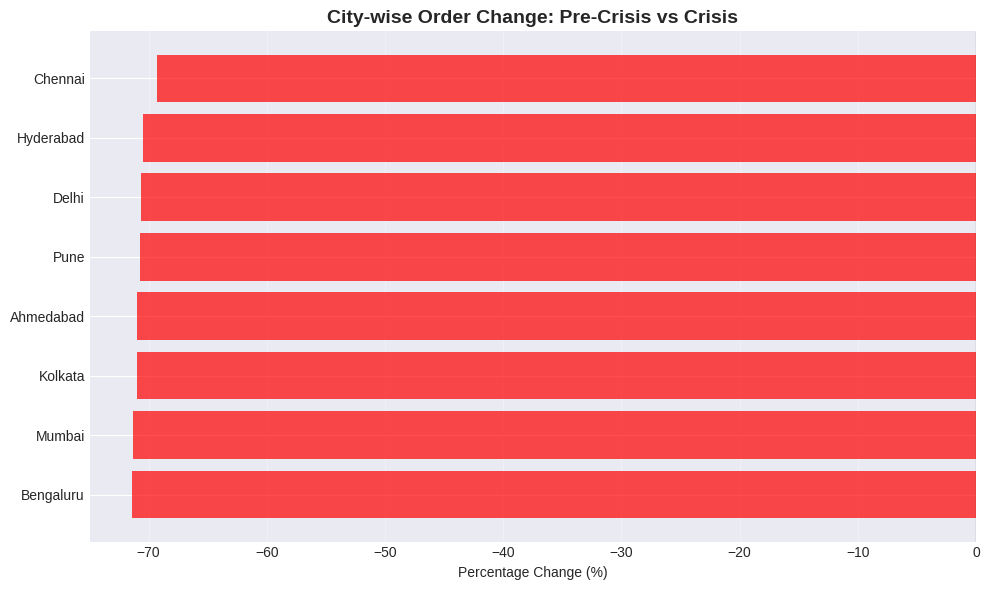

In [10]:
# Visualize city impact
plt.figure(figsize=(10, 6))
cities = city_comparison.index
x_pos = np.arange(len(cities))
colors = ['red' if x < 0 else 'green' for x in city_comparison['decline_pct']]

plt.barh(x_pos, city_comparison['decline_pct'], color=colors, alpha=0.7)
plt.yticks(x_pos, cities)
plt.xlabel('Percentage Change (%)')
plt.title('City-wise Order Change: Pre-Crisis vs Crisis', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Revenue Impact by City

In [11]:
# Revenue by city
pre_crisis_revenue_city = df_orders_city_active[
    (df_orders_city_active['year'] == 2025) & 
    (df_orders_city_active['month'].between(1, 5))
].groupby('city')['total_amount'].sum()

crisis_revenue_city = df_orders_city_active[
    (df_orders_city_active['year'] == 2025) & 
    (df_orders_city_active['month'].between(6, 9))
].groupby('city')['total_amount'].sum()

city_revenue = pd.DataFrame({
    'pre_crisis_revenue': pre_crisis_revenue_city,
    'crisis_revenue': crisis_revenue_city
}).fillna(0)

city_revenue['revenue_loss'] = city_revenue['pre_crisis_revenue'] - city_revenue['crisis_revenue']
city_revenue['revenue_decline_pct'] = (
    city_revenue['revenue_loss'] / city_revenue['pre_crisis_revenue'] * 100
)

city_revenue = city_revenue.sort_values('revenue_loss', ascending=False)

print("CITY-LEVEL REVENUE IMPACT")
print("=" * 80)
print(city_revenue.to_string())

print(f"\nTOP 3 CITIES BY REVENUE LOSS:")
print("=" * 60)
for idx, (city, row) in enumerate(city_revenue.head(3).iterrows(), 1):
    print(f"{idx}. {city}: ₹{row['revenue_loss']:,.2f} ({row['revenue_decline_pct']:.1f}%)")

CITY-LEVEL REVENUE IMPACT
           pre_crisis_revenue  crisis_revenue  revenue_loss  revenue_decline_pct
city                                                                            
Bengaluru         10635756.18      3047959.93    7587796.25            71.342330
Mumbai             6071645.80      1736092.89    4335552.91            71.406552
Delhi              5263136.37      1537761.01    3725375.36            70.782421
Hyderabad          3692107.83      1088691.34    2603416.49            70.513013
Chennai            3751962.39      1155155.77    2596806.62            69.211958
Pune               2998731.41       877417.23    2121314.18            70.740386
Ahmedabad          2615418.54       752255.50    1863163.04            71.237663
Kolkata            2592205.73       744817.64    1847388.09            71.267032

TOP 3 CITIES BY REVENUE LOSS:
1. Bengaluru: ₹7,587,796.25 (71.3%)
2. Mumbai: ₹4,335,552.91 (71.4%)
3. Delhi: ₹3,725,375.36 (70.8%)


## Key Metrics Summary

In [12]:
print("\n" + "=" * 80)
print("EXECUTIVE SUMMARY - BUSINESS HEALTH METRICS")
print("=" * 80)

print(f"\n📊 ORDER VOLUME")
print(f"  • Total Orders Decline: {decline_pct:.1f}%")
print(f"  • Monthly Average Lost: {pre_crisis_avg - crisis_avg:,.0f} orders")
print(f"  • Worst Month: {monthly_orders.loc[monthly_orders['change'].idxmin(), 'month_period']}")

print(f"\n💰 REVENUE IMPACT")
print(f"  • Total Revenue Loss: ₹{revenue_loss:,.2f}")
print(f"  • Revenue Decline: {(revenue_loss/pre_crisis_revenue*100):.1f}%")
print(f"  • Average Monthly Revenue Loss: ₹{revenue_loss/4:,.2f}")

print(f"\n❌ CANCELLATIONS")
print(f"  • Pre-Crisis Rate: {pre_crisis_cancel_rate:.2f}%")
print(f"  • Crisis Rate: {crisis_cancel_rate:.2f}%")
print(f"  • Change: {crisis_cancel_rate - pre_crisis_cancel_rate:+.2f} pp")

print(f"\n🏙️ GEOGRAPHIC IMPACT")
print(f"  • Most Affected City: {city_comparison.index[0]} ({city_comparison.iloc[0]['decline_pct']:.1f}%)")
print(f"  • Highest Revenue Loss: {city_revenue.index[0]} (₹{city_revenue.iloc[0]['revenue_loss']:,.2f})")
print(f"  • Best Performing City: {city_comparison.index[-1]} ({city_comparison.iloc[-1]['decline_pct']:.1f}%)")

print("\n" + "=" * 80)


EXECUTIVE SUMMARY - BUSINESS HEALTH METRICS

📊 ORDER VOLUME
  • Total Orders Decline: 61.2%
  • Monthly Average Lost: 13,921 orders
  • Worst Month: 2025-06

💰 REVENUE IMPACT
  • Total Revenue Loss: ₹26,680,812.94
  • Revenue Decline: 70.9%
  • Average Monthly Revenue Loss: ₹6,670,203.24

❌ CANCELLATIONS
  • Pre-Crisis Rate: 6.06%
  • Crisis Rate: 11.93%
  • Change: +5.87 pp

🏙️ GEOGRAPHIC IMPACT
  • Most Affected City: Bengaluru (-71.4%)
  • Highest Revenue Loss: Bengaluru (₹7,587,796.25)
  • Best Performing City: Chennai (-69.3%)



## Export Key Metrics for Dashboard

In [13]:
# Create output directory
output_dir = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/output')
output_dir.mkdir(exist_ok=True)

# Export datasets for Power BI
monthly_orders.to_csv(output_dir / 'monthly_orders.csv', index=False)
monthly_revenue.to_csv(output_dir / 'monthly_revenue.csv', index=False)
monthly_cancellations.to_csv(output_dir / 'monthly_cancellations.csv', index=False)
city_comparison.to_csv(output_dir / 'city_order_impact.csv')
city_revenue.to_csv(output_dir / 'city_revenue_impact.csv')

print("Exported files for dashboard:")
print("  • monthly_orders.csv")
print("  • monthly_revenue.csv")
print("  • monthly_cancellations.csv")
print("  • city_order_impact.csv")
print("  • city_revenue_impact.csv")

Exported files for dashboard:
  • monthly_orders.csv
  • monthly_revenue.csv
  • monthly_cancellations.csv
  • city_order_impact.csv
  • city_revenue_impact.csv
